# Plotting script for e22.F1850.f09_f09_mg17 Control, CRI 240 K, CRI 263 K, and CRI 273 K CESM 40 year runs
### Set up
#### Packages

In [55]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
from scipy import stats
import matplotlib as mpl
from matplotlib import font_manager
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.mathtext import _mathtext as mathtext
import matplotlib.ticker as mticker
from matplotlib import gridspec
import matplotlib.path as mpath
import matplotlib.colors as colors
import matplotlib.dates as mdates
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.filterwarnings('ignore')
import datetime as dt
from datetime import timedelta
from cmcrameri import cm
import jinja2
from Plotting_functions import wvl2wvn, wvn2wvl, p2z, z2p, t_test_two_means, Wilks_pcrit, CustomCmap, draw_circle, CalcStatSig

In [56]:
font_path = '/glade/work/glydia/conda-envs/cenv/fonts/Helvetica.ttc'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

#### Filepaths, name variables

In [ ]:
## Test numbers
tst_type = 'extended'

## Test names
control = 'f.e22.F1850.f09_f09_mg17.control_test.'
cri240K = 'f.e22.F1850.f09_f09_mg17.cri240K_test.'
cri263K = 'f.e22.F1850.f09_f09_mg17.cri263K_test.'
cri273K = 'f.e22.F1850.f09_f09_mg17.cri273K_test.'

## Significance type
sig = 'Wilks'

## Time averaging type
time_avg = 3    # 0: Monthly, 1: Yearly, 2: Seasonal, 3: All data

## Filtering
filter = False
filter_str = 'filtered' if filter else 'non_filtered'

## Filepaths
path_to_data = '/glade/work/glydia/Arctic_CRI_processed_data/processed_free_evolving_data/'
path_to_graphs = '/glade/u/home/glydia/free_evolving_40yr_graphs/'+filter_str+'/'

## Variables to process
var_list = np.array(['FLDS','T','TS', 'FLUT'])
var = var_list[0]

## Plot types to make
map_type = True

In [58]:
## Chunking variables
la_chunk = 64
lo_chunk = 96
le_chunk = 4

In [59]:
%%time

## Select plot type - yearly or monthly - to make and assign variables accordingly
# Seasonal
if time_avg == 2:
    time_str = 'Season'

# All-data average
elif time_avg == 3:
    time_str = 'All_data'
    
elif time_avg == 0:
    time_str = 'Month'
    
elif time_avg == 4:
    time_str = 'Timeseries'
    
elif time_avg == 1:
    time_str = 'Year'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


#### Load data

In [60]:
%%time

## Load data
# Load control data
control_data_avg = xr.open_dataset(path_to_data+control+var+'.avg.'+time_str+'.'+filter_str+'.nc', 
                                   chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})
if time_avg < 4:
    control_data_std = xr.open_dataset(path_to_data+control+var+'.std.'+time_str+'.'+filter_str+'.nc', 
                                       chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})
    n_control = xr.open_dataset(path_to_data+control+var+'.n.'+time_str+'.'+filter_str+'.nc', 
                                chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})

CPU times: user 10.7 ms, sys: 438 µs, total: 11.1 ms
Wall time: 59.9 ms


In [61]:
%%time

# Load cri240K data
cri240K_data_avg = xr.open_dataset(path_to_data+cri240K+var+'.avg.'+time_str+'.'+filter_str+'.nc', 
                                   chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})

if time_avg < 4:
    cri240K_data_std = xr.open_dataset(path_to_data+cri240K+var+'.avg.'+time_str+'.'+filter_str+'.nc', 
                                       chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})
    n_cri240K = xr.open_dataset(path_to_data+cri240K+var+'.n.'+time_str+'.'+filter_str+'.nc', 
                                chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})

CPU times: user 11.3 ms, sys: 407 µs, total: 11.7 ms
Wall time: 66 ms


In [62]:
%%time

# Load cri263K data
cri263K_data_avg = xr.open_dataset(path_to_data+cri263K+var+'.avg.'+time_str+'.'+filter_str+'.nc', 
                                   chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})

if time_avg < 4:
    cri263K_data_std = xr.open_dataset(path_to_data+cri263K+var+'.avg.'+time_str+'.'+filter_str+'.nc', 
                                       chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})
    n_cri263K = xr.open_dataset(path_to_data+cri263K+var+'.n.'+time_str+'.'+filter_str+'.nc', 
                                chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})

CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 43.6 ms


In [63]:
%%time

# Load cri273K data
cri273K_data_avg = xr.open_dataset(path_to_data+cri273K+var+'.avg.'+time_str+'.'+filter_str+'.nc', 
                                   chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})

if time_avg < 4:
    cri273K_data_std = xr.open_dataset(path_to_data+cri273K+var+'.avg.'+time_str+'.'+filter_str+'.nc', 
                                       chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})
    n_cri273K = xr.open_dataset(path_to_data+cri273K+var+'.n.'+time_str+'.'+filter_str+'.nc', 
                                chunks={'lat':la_chunk,'lon':lo_chunk,'lev':le_chunk})

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 35.1 ms


#### Define custom colobars

In [64]:
# Difference colorbars
tppr_levels = np.linspace(-3,3,21)
tppr_levels[10] = -0.0000000001
flux_levels = np.linspace(-10,10,21)
lwp_levels = np.linspace(-75,75,21)
iwp_levels = flux_levels
lcc_levels = np.linspace(-.5,.5,21)
wcf_levels = flux_levels
wnd_levels = flux_levels

vik_cmap = cm.vik

# Create cmap and norms
diff_cmap, tppr_norm = CustomCmap(tppr_levels,vik_cmap,[],False)
_, flux_norm = CustomCmap(flux_levels,vik_cmap,[],False)
_, lwp_norm = CustomCmap(lwp_levels,vik_cmap,[],False)
_, iwp_norm = CustomCmap(iwp_levels,vik_cmap,[],False)
_, lcc_norm = CustomCmap(lcc_levels,vik_cmap,[],False)
_, wcf_norm = CustomCmap(wcf_levels,vik_cmap,[],False)
_, wnd_norm = CustomCmap(wnd_levels,vik_cmap,[],False)

### Spatial plots
#### Set up

In [ ]:
if map_type:    
    graph_type_str = 'Map'# Linear or Map or Zonal
    plot_type = time_avg # 0: Monthly, 2: Seasonal, 3: All years
    num_yrs = 40

    ## Select plot type - yearly or monthly - to make and assign variables accordingly
    # Seasonal
    if plot_type == 2:
        avg_list = np.arange(4)
        date_str = np.array(['DJF','JJA','MAM','SON'])
        title_str = date_str 

    # All-data average
    elif plot_type == 3:
        avg_list = np.arange(1)
        date_str = np.array(['all_yrs'])
        title_str = np.array(['Ensemble mean for '+str(num_yrs)+' year average'])
        
    # Monthly
    elif plot_type == 0:
        avg_list = np.arange(12)
        date_str = np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    
    # Yearly
    elif plot_type == 1:
        avg_list = np.arange(40)
        date_str = np.array([str(i+1979) for i in np.arange(1,41,1)])
        


#### Define graphing variables

In [ ]:
if map_type:     
    # Graphing variables 
    sbpt_shp = (1,4)
    figsz = (12,3)
    proj = ccrs.NorthPolarStereo()
    extent = [-180, 180, 50, 90]

#### Calculate statistical signficance based on Wilks test

In [67]:
%%time
if map_type: 
    ## Calculate p-vals for t-test & Wilks field significance for all variables in varplot
    cri240K_data_avg = CalcStatSig(control_data_avg, control_data_std, n_control, 
                                   cri240K_data_avg, cri240K_data_std, n_cri240K, 
                                   var, sig, 'Mean', time_avg)
    cri263K_data_avg = CalcStatSig(control_data_avg, control_data_std, n_control, 
                                   cri263K_data_avg, cri263K_data_std, n_cri263K, 
                                   var, sig, 'Mean', time_avg)
    cri273K_data_avg = CalcStatSig(control_data_avg, control_data_std, n_control, 
                                   cri273K_data_avg, cri273K_data_std, n_cri273K, 
                                   var, sig, 'Mean', time_avg)

CPU times: user 233 ms, sys: 2.79 ms, total: 236 ms
Wall time: 422 ms


In [68]:
%%time

# load computations into dataset
if map_type: 
    control_data_avg.compute()
    cri240K_data_avg.compute()
    cri263K_data_avg.compute()
    cri273K_data_avg.compute()

CPU times: user 20.5 ms, sys: 0 ns, total: 20.5 ms
Wall time: 20.5 ms


In [ ]:
if map_type:     
    # Plotting pandas Dataframe for spatial plots
    spdf = pd.DataFrame(data={'cmap':[cm.navia,plt.cm.jet,plt.cm.Blues,plt.cm.Blues,cm.lajolla_r,cm.lajolla_r,cm.lajolla_r,cm.lajolla_r,cm.roma_r,cm.roma_r,cm.navia,cm.navia],
                               'norm': [lcc_norm,tppr_norm,lwp_norm,iwp_norm,flux_norm,flux_norm,flux_norm,flux_norm,wcf_norm,wcf_norm,tppr_norm,tppr_norm],
                               'cnt_cbar_lb': ['LCC frequency','Surface temperature (K)','LWP (g/m$^{2}$)','IWP (g/m$^{2}$)','Downwelling longwave flux\nat the surface (W m$^{-2}$)',
                                               'F$_{\downarrow}$ (SW, surface) (W/m$^{2}$)',r'F$_{\uparrow}$ (LW, TOA) (W/m$^{2}$)',r'F$_{\uparrow}$ (SW, TOA) (W/m$^{2}$)',
                                               'LWCF (W/m$^{2}$)','SWCF (W/m$^{2}$)','Large-scale precipitation rate (mm/day)','Large-scale snow rate (mm/day)'],
                               'diff_cbar_lb': ['LCC frequency difference','Temperature difference (K)','LWP difference (g/m$^{2}$)','IWP difference (g/m$^{2}$)','Flux difference (W m$^{-2}$)',
                                                'Flux difference (W/m$^{2}$)','Flux difference (W/m$^{2}$)','Flux difference (W/m$^{2}$)','LWCF difference (W/m$^{2}$)','SWCF difference (W/m$^{2}$)',
                                                'Precipitation rate difference (mm/day)','Snow rate difference (mm/day)'],
                               'suptitle': ['Liquid-containing cloud frequency [LCC]','Surface temperature [TS]','Liquid water path [TGCLDLWP]','Ice water path [TGCLDIWP]',
                                            'Downwelling longwave flux at the surface [FLDS]','Downwelling shortwave flux at the surface [FSDS]','Upwelling longwave flux at the TOA [FLUT]',
                                            'Upwelling shortwave flux at the TOA [FSUTOA]','Longwave cloud forcing [LWCF]','Shortwave cloud forcing [SWCF]',
                                            'Large-scale precipitation rate [PRECL]','Large-scale snow rate [PRECSL]'],
                               'add_units': [' ',' K', ' g m$^{-2}$', ' g m$^{-2}$', ' W m$^{-2}$', ' W m$^{-2}$', ' W m$^{-2}$', ' W m$^{-2}$', ' W m$^{-2}$', ' W m$^{-2}$', ' mm day$^{-1}$', ' mm day$^{-1}$']},
                        index=['LCC','TS','TGCLDLWP','TGCLDIWP','FLDS','FSDS','FLUT','FSUTOA','LWCF','SWCF','PRECL','PRECSL'])


In [70]:
if map_type:
    ## Loop through all months/years
    for j in avg_list:
        if plot_type == 2:
            index = dict(season=j)
        elif plot_type >= 3:
            index = dict()

        print(date_str[j])
        cri240K_diff = cri240K_data_avg[var][index]-control_data_avg[var][index]
        cri263K_diff = cri263K_data_avg[var][index]-control_data_avg[var][index]
        cri273K_diff = cri273K_data_avg[var][index]-control_data_avg[var][index]

        print('max control-cri240K diff: '+str(cri240K_diff.loc[dict(lat=slice(50,90))].max().values))
        print('min control-cri240K diff: '+str(cri240K_diff.loc[dict(lat=slice(50,90))].min().values))
        print('max control-cri263K diff: '+str(cri263K_diff.loc[dict(lat=slice(50,90))].max().values))
        print('min control-cri263K diff: '+str(cri263K_diff.loc[dict(lat=slice(50,90))].min().values))
        print('max control-cri273K diff: '+str(cri273K_diff.loc[dict(lat=slice(50,90))].max().values))
        print('min control-cri273K diff: '+str(cri273K_diff.loc[dict(lat=slice(50,90))].min().values))

all_yrs
max control-cri240K diff: 3.837677
min control-cri240K diff: -3.1137238
max control-cri263K diff: 3.6671753
min control-cri263K diff: -2.0112762
max control-cri273K diff: 3.0583954
min control-cri273K diff: -1.5473022


In [ ]:
if map_type:
    slice_i = dict(lat=slice(60,90))
    avg_dim = ('lat','lon')
    
    weights = np.cos(np.deg2rad(cri240K_diff.lat.loc[slice_i]))
    weights.compute()
    
    # Weight ensemble member data
    cri240K_diff_w = cri240K_diff.loc[slice_i].weighted(weights)
    cri263K_diff_w = cri263K_diff.loc[slice_i].weighted(weights)
    cri273K_diff_w = cri273K_diff.loc[slice_i].weighted(weights)

    cri240K_diff_w = cri240K_diff.weighted(weights)
    cri263K_diff_w = cri263K_diff.weighted(weights)
    cri273K_diff_w = cri273K_diff.weighted(weights)
    
    # Calculate weighted mean
    cri240K_diff_avg_w = cri240K_diff_w.mean(avg_dim,skipna=True)
    cri263K_diff_avg_w = cri263K_diff_w.mean(avg_dim,skipna=True)
    cri273K_diff_avg_w = cri273K_diff_w.mean(avg_dim,skipna=True)

#### Make plots

CPU times: user 9.09 s, sys: 31 ms, total: 9.12 s
Wall time: 9.66 s


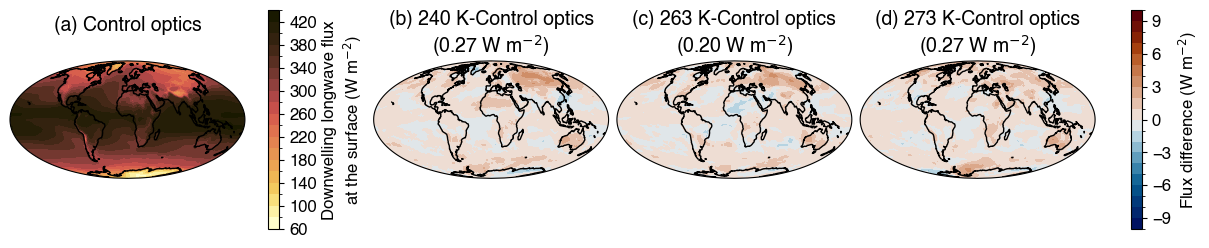

In [ ]:
%%time

if map_type:
    ## Loop through all months/years
    for j in avg_list:
        if plot_type == 2:
            index = dict(season=j)
        elif plot_type >= 3:
            index = dict()
        elif plot_type == 0:
            index = dict(month=j)
        elif plot_type == 1:
            index = dict(year=j)


        # Set up
        # fig, axlist = plt.subplots(sbpt_shp[0],sbpt_shp[1],layout='constrained',subplot_kw=dict(projection=proj))
        fig, axlist = plt.subplots(sbpt_shp[0],sbpt_shp[1],layout='constrained',subplot_kw=dict(projection=ccrs.Mollweide()))
        fig.set_size_inches(figsz[0],figsz[1])

        if sig == 'Wilks':
            if plot_type >= 3:
                pcriti_cri240K = cri240K_data_avg['pcrit_'+var][index].values[0][0]
                pcriti_cri263K = cri263K_data_avg['pcrit_'+var][index].values[0][0]
                pcriti_cri273K = cri273K_data_avg['pcrit_'+var][index].values[0][0]
            else:
                pcriti_cri240K = cri240K_data_avg['pcrit_'+var][index].values[0]
                pcriti_cri263K = cri263K_data_avg['pcrit_'+var][index].values[0]
                pcriti_cri273K = cri273K_data_avg['pcrit_'+var][index].values[0]

        # Plot data
        cax = control_data_avg[var][index].plot.contourf(
            ax=axlist[0],cmap=spdf.loc[var]['cmap'],levels=20,
            add_colorbar=False,transform=ccrs.PlateCarree(),zorder=1)
        cax2 = (cri240K_data_avg[var][index]-control_data_avg[var][index]).plot.contourf(
            ax=axlist[1],add_colorbar=False,cmap=diff_cmap,
            norm=spdf.loc[var]['norm'],transform=ccrs.PlateCarree(),zorder=1)
        (cri263K_data_avg[var][index]-control_data_avg[var][index]).plot.contourf(
            ax=axlist[2],add_colorbar=False,cmap=diff_cmap,
            norm=spdf.loc[var]['norm'],transform=ccrs.PlateCarree(),zorder=1)
        (cri273K_data_avg[var][index]-control_data_avg[var][index]).plot.contourf(
            ax=axlist[3],add_colorbar=False,cmap=diff_cmap,
            norm=spdf.loc[var]['norm'],transform=ccrs.PlateCarree(),zorder=1)


        cri240K_data_avg['pvals_'+var][index].plot.contourf(
            ax=axlist[1],levels=[-0.01,pcriti_cri240K,1],hatches=['...',None],colors='none',
            add_colorbar=False,transform=ccrs.PlateCarree(),zorder=2)
        cri263K_data_avg['pvals_'+var][index].plot.contourf(
            ax=axlist[2],levels=[-0.01,pcriti_cri263K,1],hatches=['...',None],colors='none',
            add_colorbar=False,transform=ccrs.PlateCarree(),zorder=2)
        cri273K_data_avg['pvals_'+var][index].plot.contourf(
            ax=axlist[3],levels=[-0.01,pcriti_cri273K,1],hatches=['...',None],colors='none',
            add_colorbar=False,transform=ccrs.PlateCarree(),zorder=2)

        # Formatting
        axlist[0].coastlines(zorder=3)
        axlist[0].set_extent(extent, ccrs.PlateCarree())
        draw_circle(axlist[0], draw_major=False, draw_major_labels=False)
        axlist[0].set_title('(a) Control optics\n', fontsize=14)
        # gl0.xlabel_style = {'size':11}
        # gl0.ylabel_style = {'size':11}

        cb1 = fig.colorbar(cax,ax=axlist[0],pad=0.1,shrink=0.75,fraction=0.1)
        cb1.set_label(label=spdf.loc[var]['cnt_cbar_lb'], fontsize=12)
        cb1.ax.tick_params(labelsize=12)

        axlist[1].coastlines(zorder=3)
        axlist[1].set_extent(extent, ccrs.PlateCarree())
        draw_circle(axlist[1], draw_major=False, draw_major_labels=False)
        axlist[1].set_title('(b) 240 K-Control optics\n({:.2f}'.format(cri240K_diff_avg_w.values)+spdf.loc[var]['add_units']+')', fontsize=14)
        # gl1.xlabel_style = {'size':11}
        # gl1.ylabel_style = {'size':11}

        axlist[2].coastlines(zorder=3)
        axlist[2].set_extent(extent, ccrs.PlateCarree())
        draw_circle(axlist[2], draw_major=False, draw_major_labels=False)
        axlist[2].set_title('(c) 263 K-Control optics\n({:.2f}'.format(cri263K_diff_avg_w.values)+spdf.loc[var]['add_units']+')', fontsize=14)
        # gl1.xlabel_style = {'size':11}
        # gl1.ylabel_style = {'size':11}

        axlist[3].coastlines(zorder=3)
        axlist[3].set_extent(extent, ccrs.PlateCarree())
        draw_circle(axlist[3], draw_major=False, draw_major_labels=False)
        axlist[3].set_title('(d) 273 K-Control optics\n({:.2f}'.format(cri273K_diff_avg_w.values)+spdf.loc[var]['add_units']+')', fontsize=14)
        # gl1.xlabel_style = {'size':11}
        # gl1.ylabel_style = {'size':11}

        cb2 = fig.colorbar(cax2,ax=axlist[1:4],pad=0.05,extend='both',shrink=0.75,fraction=0.1)
        cb2.set_label(label=spdf.loc[var]['diff_cbar_lb'], fontsize=12)
        cb2.ax.tick_params(labelsize=12)

        #fig.suptitle(spdf.loc[var]['suptitle']+' - '+title_str[j])

        fig.savefig(path_to_graphs+var+'.'+graph_type_str+'.'+date_str[j]+'.pdf',dpi=400,bbox_inches='tight')

        plt.close(fig)
        axlist[0].clear()
        axlist[1].clear()
        axlist[2].clear()
        axlist[3].clear()